# Sentiment Analysis

EDA, preprocessing and test evaluation included.

Model used: Logistic Regression


In [1]:
!pip install emoji

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import pickle
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import statsmodels.api as sm
from statsmodels.formula.api import ols
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# load the data
df = pd.read_csv('/kaggle/input/csgo-steam-reviews/csgo_steam_reviews.csv', header = 0)

In [4]:
df.head()

,id,language,review,created,voted_up,votes_up,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author.num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,133848242,english,Pretty good game all around.\nGreat game! I wo...,2023-03-01 09:17:12,True,0,0,True,True,False,8,1,44277,1075,44277,2023-03-01 09:04:32
1,133848123,english,haha smiriva me\n,2023-03-01 09:13:21,True,0,0,False,False,False,1,1,2169,2169,2169,2023-03-01 09:16:29
2,133848052,english,full of cheaterts roblox has better anti cheat,2023-03-01 09:11:10,False,0,0,True,False,False,18,3,15619,1976,15603,2023-03-01 09:15:00
3,133847297,english,"Good game, kinda racist but good.",2023-03-01 08:45:24,True,0,0,True,False,False,10,1,14826,2452,14826,2023-02-27 21:09:37
4,133847187,english,mrazq rusnacite ama ovr stava,2023-03-01 08:41:36,True,0,0,True,False,False,10,1,5045,400,4984,2023-03-01 09:30:07


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15640 entries, 0 to 15639
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              15640 non-null  int64 
 1   language                        15640 non-null  object
 2   review                          15586 non-null  object
 3   created                         15640 non-null  object
 4   voted_up                        15640 non-null  bool  
 5   votes_up                        15640 non-null  int64 
 6   comment_count                   15640 non-null  int64 
 7   steam_purchase                  15640 non-null  bool  
 8   recieved_for_free               15640 non-null  bool  
 9   written_during_early_access     15640 non-null  bool  
 10  author.num_games_owned          15640 non-null  int64 
 11  author_num_reviews              15640 non-null  int64 
 12  author_playtime_forever         15640 non-null

### Nans

In [6]:
df.isnull().sum()

id                                 0
language                           0
review                            54
created                            0
voted_up                           0
votes_up                           0
comment_count                      0
steam_purchase                     0
recieved_for_free                  0
written_during_early_access        0
author.num_games_owned             0
author_num_reviews                 0
author_playtime_forever            0
author_playtime_last_two_weeks     0
author_playtime_at_review          0
author_last_played                 0
dtype: int64

There are 54 samples with no text. As text information is crutial for us, we are going to remove these samples for both EDA anf models fitting.

In [7]:
# drop samples with nans
df.dropna(inplace = True, axis = 0)
df.reset_index(drop = True, inplace = True)

### Text stats

In [8]:
texts = df['review']

In [9]:
text_lens = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_lens)

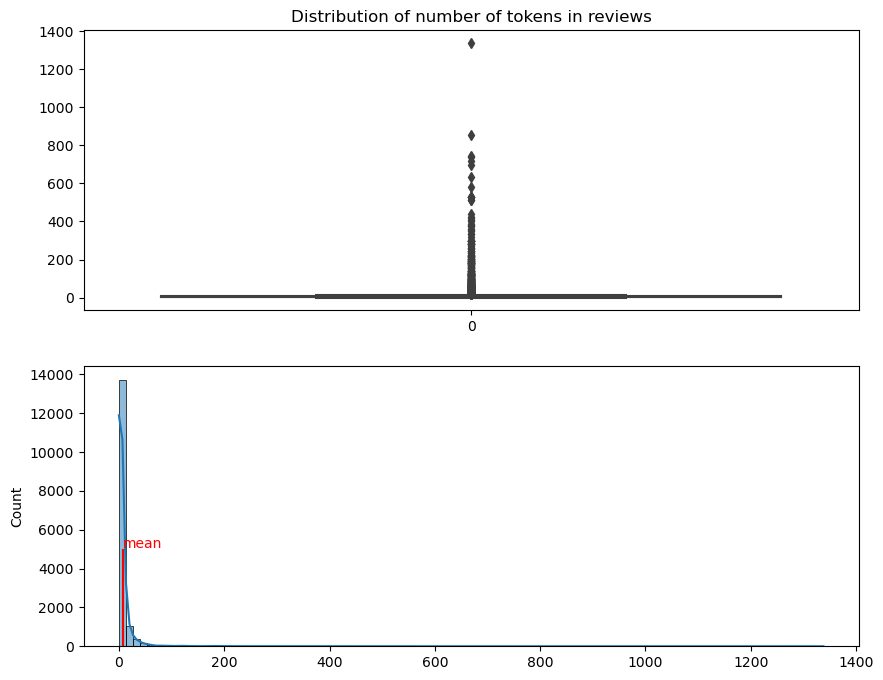

In [10]:
fig, axes = plt.subplots(2, 1, figsize = (10, 8))
axes[0].set_title('Distribution of number of tokens in reviews')
sns.boxplot(text_lens, ax = axes[0])
sns.histplot(text_lens, bins = 100, kde = True, ax = axes[1])
axes[1].vlines(len_mean, 0, 5000, color = 'r')
plt.annotate("mean", xy = (len_mean, 5000), xytext = (len_mean - 2, 5050),
            color = 'r')
plt.show()

Mean length of reviews is nearly about 20 tokens. The distribution is scewed positively and a few outliers are observed on the right tail. Some of them are clode to the right whisker but some are located far from the majority of points. Let investigate them!

In [11]:
extreme_outliers = df['review'][np.array(text_lens) > 450]

In [12]:
for idx in extreme_outliers.index:
    print(idx, 'Target', df['voted_up'][idx])
    print(extreme_outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

3405 Target True
According to all known laws
of aviation,

  
there is no way a bee
should be able to fly.

  
Its wings are too small to get
its fat little body off the ground.

  
The bee, of course, flies anyway

  
because bees don't care
what humans think is impossible.

  
Yellow, black. Yellow, black.
Yellow, black. Yellow, black.

  
Ooh, black and yellow!
Let's shake it up a little.

  
Barry! Breakfast is ready!

  
Ooming!

  
Hang on a second.

  
Hello?

  
- Barry?
- Adam?

  
- Oan you believe this is happening?
- I can't. I'll pick you up.

  
Looking sharp.

  
Use the stairs. Your father
paid good money for those.

  
Sorry. I'm excited.

  
Here's the graduate.
We're very proud of you, son.

  
A perfect report card, all B's.

  
Very proud.

  
Ma! I got a thing going here.

  
- You got lint on your fuzz.
- Ow! That's me!

  
- Wave to us! We'll be in row 118,000.
- Bye!

  
Barry, I told you,
stop flying in the house!

  
- Hey, Adam.
- Hey, Barry.

  
- Is that f

Some of these reviews do not contain any textual information. Such precendents could be removed. Some have both meaningful part and plenty of punctuation characters. They could be removed on the preprocessing stage.

Lets investigate outliers points which are closer to the majotiry.

In [13]:
outliers = df['review'][np.array(text_lens) > 350]

In [14]:
for idx in outliers.index:
    print(idx, 'Target', df['voted_up'][idx])
    print(outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

2243 Target True
As someone who has been playing Counter-Strike: Global Offensive (CS:GO) for over a decade now, I can confidently say that this game has become an integral part of my life. With its intense gameplay, strategic depth, and endless replayability, CS:GO has remained one of the most engaging and exciting competitive games in the world.

One of the things that I appreciate the most about CS:GO is its emphasis on teamwork and communication. In order to succeed in this game, players must work together to devise and execute effective strategies, communicate effectively, and rely on each other's strengths to overcome the enemy team. This not only creates a sense of camaraderie and teamwork, but also encourages players to develop important skills such as leadership, communication, and decision-making.

Another aspect of CS:GO that has kept me hooked for so long is its intricate and complex gameplay mechanics. From the various weapons and grenades to the different types of maps an

Most of these reviews seem to be meaningful.

I am concerned about the reviews including repeated words.

### Target Analysis

In [15]:
for i in range(len(df)):
    if df['voted_up'][i] == True:
        df['voted_up'][i] = 'Positive'
    else:
        df['voted_up'][i] = 'Negative'

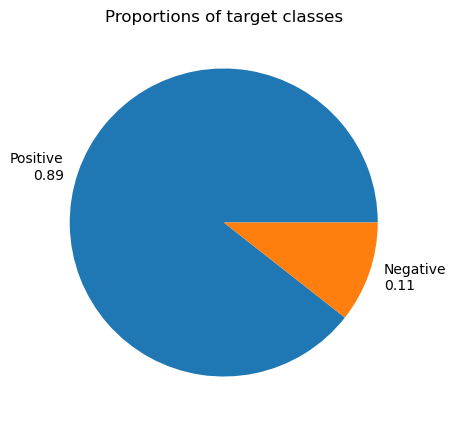

In [16]:
# balance
target_balance = df['voted_up'].value_counts()

plt.figure(figsize = (5, 5))
plt.pie(target_balance, labels = [f'{idx}\n{round(target_balance[idx]/len(df), 2)}' for idx in target_balance.index])
plt.title('Proportions of target classes')
plt.show()

Target categories are of unequal sizes, so resampling is required.

In [17]:
# top words
stopwords_list = stopwords.words('english')

word_counts = {'Positive': [], 'Negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(df['review'], df['voted_up']):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)
               

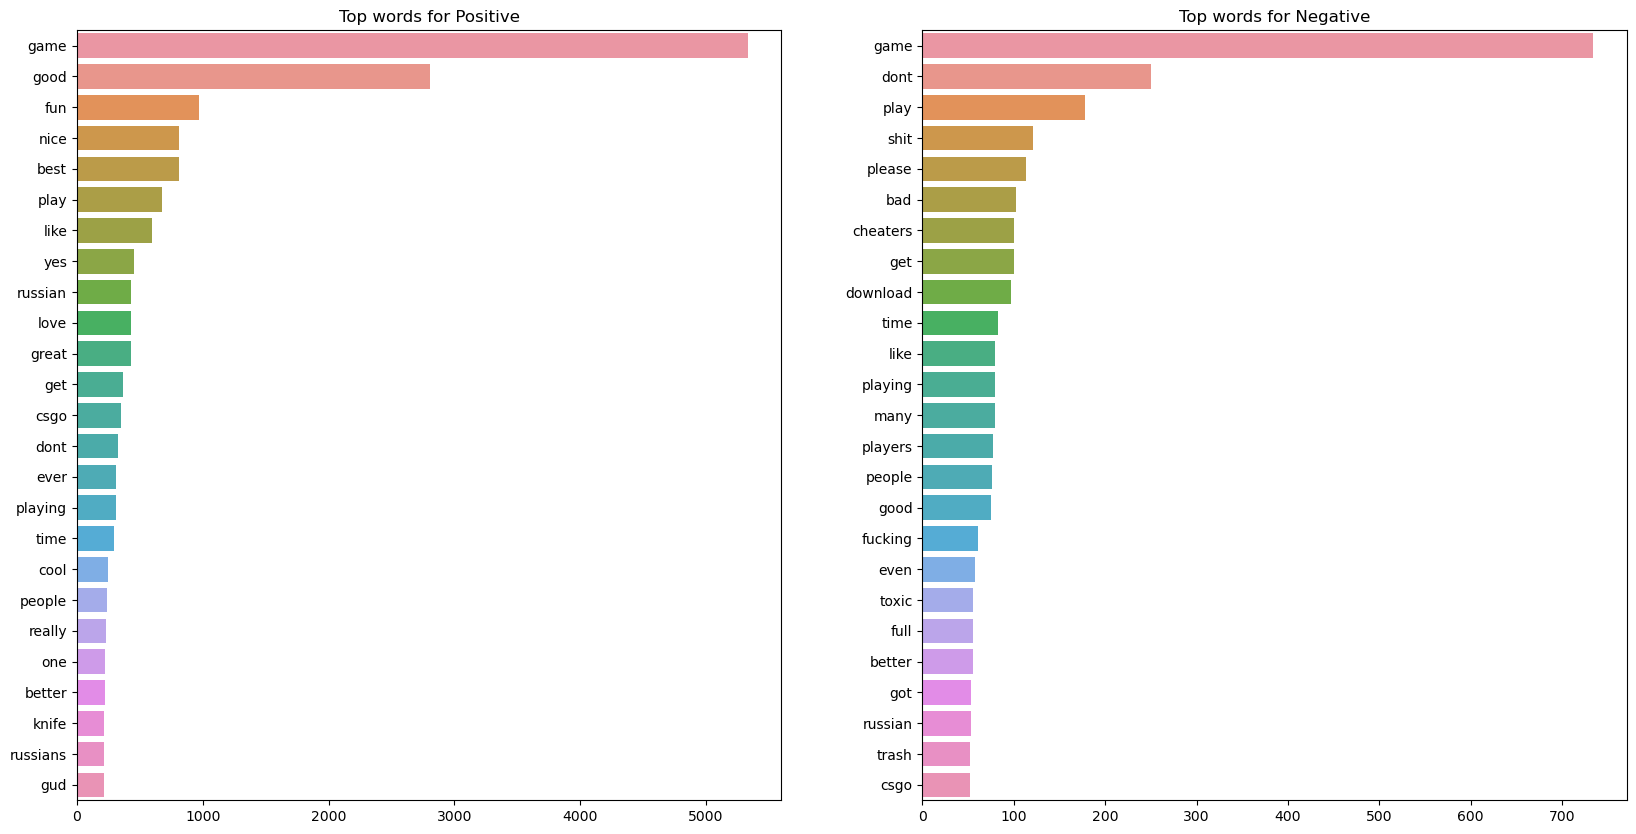

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x = bar_info.values, y = bar_info.index, ax = axis)
    axis.set_title(f'Top words for {target}')
plt.show()

We can see a clear difference between Positive and Negative. In "Negative", instead, we observe lots of swear words. To sum up, distribution of top-frequent words is different across target categories.

Now, lets see most correlated words for each topic using chi2.

In [19]:
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5,
                        ngram_range = (1, 2), 
                        stop_words = 'english',
                        max_features = 10000)

features = tfidf.fit_transform(df['review']).toarray()
labels = df['voted_up']

print("Each of the %d Text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 15586 Text is represented by 2924 features (TF-IDF score of unigrams and bigrams)


In [20]:
# len for classes without outliers
reviews_len = {'Positive': [], 'Negative': []}
pattern = re.compile('[^\w ]')
reviews_len = pd.DataFrame([len(re.sub(pattern, '', text).lower().split()) for text in df['review'] if len(text) < 400],
                         columns = ['len'])

In [21]:
reviews_len['voted_up'] = df['voted_up']

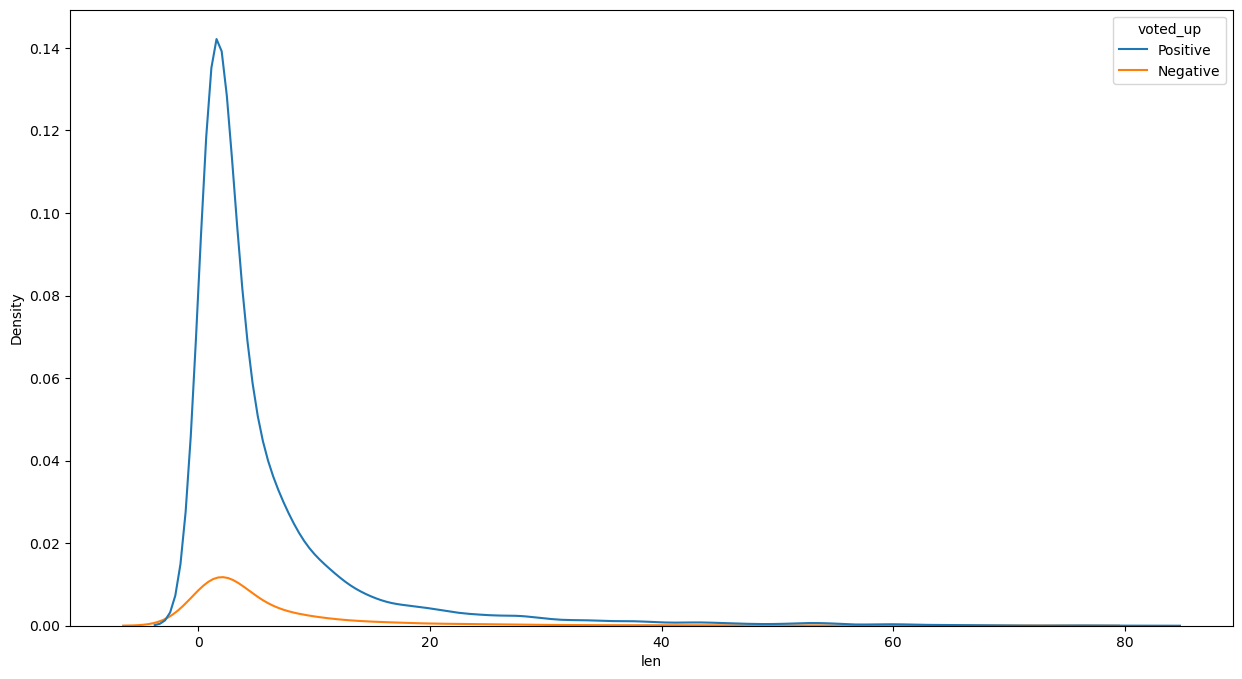

In [22]:
plt.figure(figsize = (15, 8))
sns.kdeplot(data = reviews_len, x = 'len', hue = 'voted_up')
plt.show()

Distributions of reviews length do differ from each other. We can ensure using ANOVA test as we have equal dispesion and normal-like distribution.

In [23]:
#perform two-way ANOVA
model = ols('len ~ voted_up', data = reviews_len).fit()
sm.stats.anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
voted_up,3.581384e+02,1.0,4.894958,0.02695
Residual,1.122494e+06,15342.0,NaN,NaN


p-value < 0.05, we have sufficient evidence to reject H0.

In [24]:
# emoticons

def split_count(text):
    emoji_list = []
    #data = re.findall(r'\x', text)
    for word in text:
        emojis = emoji.distinct_emoji_list(word)
        emoji_list.extend([emoji.demojize(is_emoji) for is_emoji in emojis])
        # if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
        #     emoji_list.append(word)
    
    return emoji_list

In [25]:
target_emojis = {'Positive': [], 'Negative': []}

pattern = re.compile('\u200d')
for i, text in enumerate(texts):
    emoji_count = split_count(text)
    if emoji_count:
        emoji_count = [re.sub(pattern, '', e) for e in emoji_count]
        target_emojis[df['voted_up'].iloc[i]].extend(emoji_count)

Top emojis for Positive 
 [':check_box_with_check:', ':heart_suit:', ':thumbs_up:', ':crown:', ':black_square_button:', ':check_mark_button:', ':revolving_hearts:', ':file_folder:', ':fire:', ':red_heart:', ':face_with_tears_of_joy:', ':smiling_face_with_hearts:', ':growing_heart:', ':blue_heart:', ':yellow_heart:', ':OK_hand:', ':beaming_face_with_smiling_eyes:', ':thinking_face:', ':medium_skin_tone:', ':purple_heart:']


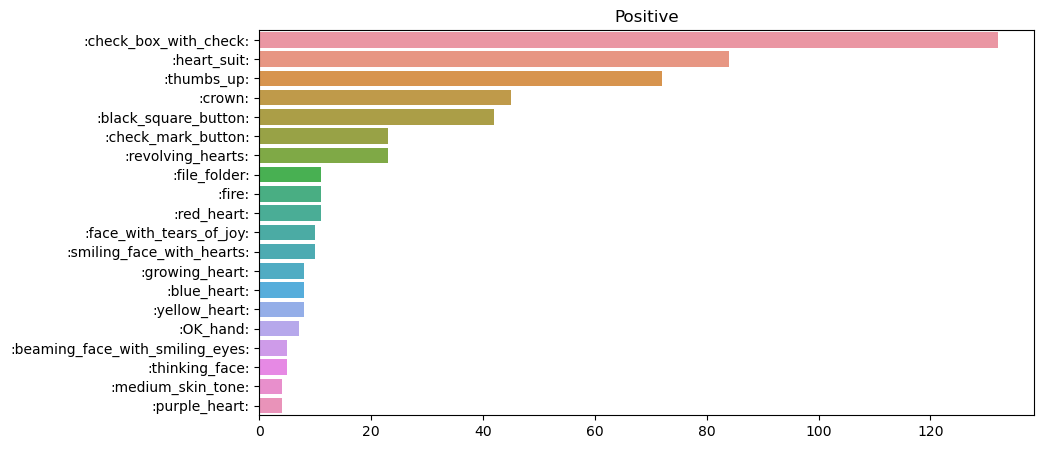

Top emojis for Negative 
 [':nerd_face:', ':eye:', ':moai:', ':folded_hands:', ':rolling_on_the_floor_laughing:', ':backhand_index_pointing_right:', ':thumbs_down:']


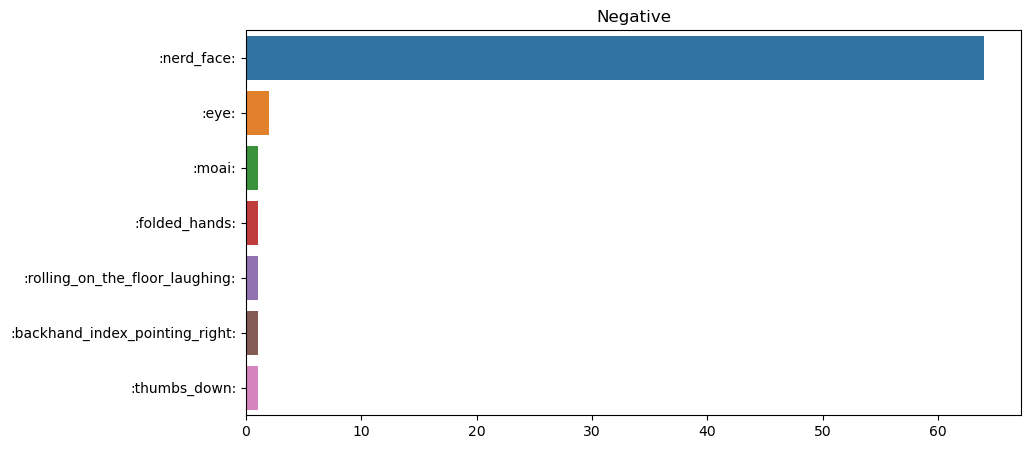

In [26]:
for t, emojis in target_emojis.items():
    plt.figure(figsize=(10, 5))
    bar_info = pd.Series(emojis).value_counts()[:20]
    print('=========='*10,  f'\nTop emojis for {t} \n', list(bar_info.index))
    bar_info.index = [emoji.demojize(i, delimiters=("", "")) for i in bar_info.index]
    sns.barplot(x=bar_info.values, y=bar_info.index)
        
    plt.title(f'{t}')
    plt.show()

## Preprocessing

Sentiment information is mostly expressed on the lexical and punctuational levels. For internet discourse we can also use emoticons as their main purpose is to represent emotions which are our target.

Thus, syntactic relations are not really important to us. As well as semantic features of words. So, we can use simple tf-idf encoders in which we also enclude punctuation (mostly exclamation and question marks), case (CapsLoc as a signal of strong emotions) and emojis.

Required preparation steps:
1. lowercase words, but count for each text how many characters or words we capitalized.
1. remove stopwords and numbers as sentiment neutral
1. decode emojis
1. lemmatize
1. vectorize with tf-idf.
1. Add refers to feature ohe
1. delete nans

Additionally perform feature selection with chi2

In [27]:
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import English
import emoji
import spacy
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError

import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
class Preprocessor:
    def __init__(self, stopwords = stopwords):
        self.vectorizer = TfidfVectorizer(lowercase = False, max_features = 8000,
                                         min_df = 10, ngram_range = (1, 3),
                                         tokenizer = None)
        self.stopwords = stopwords
        self.vectorizer_fitted = False
        
    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, '', text) for text in texts]
    
    def remove_double_space(self, texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_punctuation(self, texts):
        print('Removing Punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stopwords] for text in tqdm_notebook(texts)]
    
    def remove_numbers(self, texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm_notebook(texts)]
    
    def decode_emojis(self, texts):
        print('Decoding emojis...')
        return [emoji.demojize(text, language='en') for text in texts] 
    
    def lemmatize(self, texts):
        print('Lemmatizing...')
        lemmatized_texts = []
        for text in tqdm_notebook(texts):
            doc = nlp(text)
            lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
                                    
        return lemmatized_texts
        
    def transform(self, X, y=None, mode='train'):
        X = X.copy()
        print('Removing Nans...')
        X = X[~X.isnull()]                          # delete nans
        X = X[~X.duplicated()]                      # delete duplicates
        
        if mode == 'train':
            self.train_idx = X.index
        else:
            self.test_idx = X.index
        print('Counting capitalized...')
        capitalized = [np.sum([t.isupper() for t in text.split()]) 
                           for text in np.array(X.values)]  # count capitalized
        # X['cap'] = capitalized
        print('Lowering...')
        X = [text.lower() for text in X]             # lower
        X = self.remove_urls(X)                      # remove urls
        X = self.remove_punctuation(X)               # remove punctuation
        X = self.remove_double_space(X)              # remove double space
        X = self.decode_emojis(X)                    # decode emojis
        X = self.remove_stopwords(X)                 # remove stopwords
        X = self.remove_numbers(X)                   # remove numbers                      
        X = self.lemmatize(X)                        # lemmatize
        
        if not self.vectorizer_fitted:
            self.vectorizer_fitted = True
            print('Fitting vectorizer...')
            self.vectorizer.fit(X)

        print('Vectorizing...')
        X = self.vectorizer.transform(X)             # vectorize
        
        return X

In [29]:
pr = Preprocessor()

In [30]:
x = df['review']
y = df['voted_up']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [31]:
x_train = pr.transform(x_train)
x_train = pd.DataFrame.sparse.from_spmatrix(x_train, columns = pr.vectorizer.get_feature_names_out())

# ohe = OneHotEncoder()
# referring_ohe = ohe.fit_transform(x_train['refers to'][x_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
# referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

#x_train = pd.concat([data_train_pr, referring_ohe], axis=1)

y_train = y_train[y_train.index.isin(pr.train_idx)]
y_train.index = x_train.index

Removing Nans...
Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


  0%|          | 0/9175 [00:00<?, ?it/s]

Removing numbers...


  0%|          | 0/9175 [00:00<?, ?it/s]

Lemmatizing...


  0%|          | 0/9175 [00:00<?, ?it/s]

Fitting vectorizer...
Vectorizing...


In [32]:
x_test = pr.transform(x_test)
x_test = pd.DataFrame.sparse.from_spmatrix(x_test, columns = pr.vectorizer.get_feature_names_out())

# ohe = OneHotEncoder()
# referring_ohe = ohe.fit_transform(data_train['refers to'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
# referring_ohe = ohe.transform(x_test['refers to'][x_test.index.isin(pr.test_idx)].to_numpy().reshape(-1, 1))
# referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

# X_test = pd.concat([x_test, referring_ohe], axis=1)

y_test = y_test[y_test.index.isin(pr.train_idx)]
y_test.index = x_test.index

Removing Nans...
Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


  0%|          | 0/2472 [00:00<?, ?it/s]

Removing numbers...


  0%|          | 0/2472 [00:00<?, ?it/s]

Lemmatizing...


  0%|          | 0/2472 [00:00<?, ?it/s]

Vectorizing...


In [33]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(9175, 1120) (9175,)
(2472, 1120) (2472,)


In [34]:
# save prepared data for the future

# with open('../x_train.pkl', 'wb') as f:
#     pickle.dump(x_train, f)
# with open('../x_test.pkl', 'wb') as f:
#     pickle.dump(x_test, f)

# with open('../y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('../y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)
    
# with open('../X_train.pkl', 'rb') as f:
#     X_train = pickle.load(f)
# with open('../X_test.pkl', 'rb') as f:
#     X_test = pickle.load(f)
# with open('../y_train.pkl', 'rb') as f:
#     y_train = pickle.load(f)
# with open('../y_test.pkl', 'rb') as f:
#     y_test = pickle.load(f)

# Training

In [35]:
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix

In [36]:
def train_cv(model, X_train, y_train, params, n_splits = 5, scoring = 'f1_weighted'):
    kf = KFold(n_splits = n_splits, random_state = 0, shuffle = True)

    cv = RandomizedSearchCV(model,
                        params,
                        cv=kf,
                        scoring=scoring,
                        return_train_score=True,
                        n_jobs=-1,
                        verbose=2,
                        random_state=1
                        )
    cv.fit(X_train, y_train)

    print('Best params', cv.best_params_)
    return cv

In [37]:
rs_parameters = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': uniform(scale=10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'l1_ratio': uniform(scale=10)
    }

1. Without feature selection
2. MI feature selection

## Training without feature selection

In [38]:
lr = LogisticRegression()
model_cv_lr = train_cv(lr, x_train, y_train, rs_parameters)

bestimator_lr = model_cv_lr.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params {'C': 8.650202519789833, 'l1_ratio': 8.291469073671415, 'penalty': 'l2', 'solver': 'lbfgs'}


In [39]:
print(classification_report(y_test, bestimator_lr.predict(x_test)))

              precision    recall  f1-score   support

    Negative       0.52      0.22      0.31       299
    Positive       0.90      0.97      0.93      2173

    accuracy                           0.88      2472
   macro avg       0.71      0.60      0.62      2472
weighted avg       0.85      0.88      0.86      2472



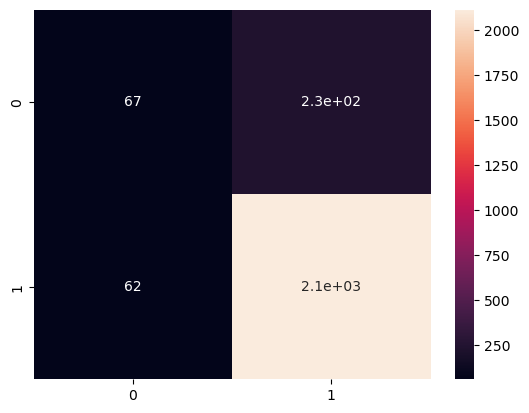

In [40]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(x_test)), annot=True)
plt.show()

Pretty descend score for a baseline. All classes are predicted almost equally good, confusion matrix look diagonal.

Let's look if we could get the same score after droping some the least important features according to Mutual Information score.

## With MI feature selection

In [41]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(x_train,y_train)

In [42]:
cols_importance = sorted(list(zip(x_train.columns, mi_score)), key=lambda x: x[1], reverse=True)

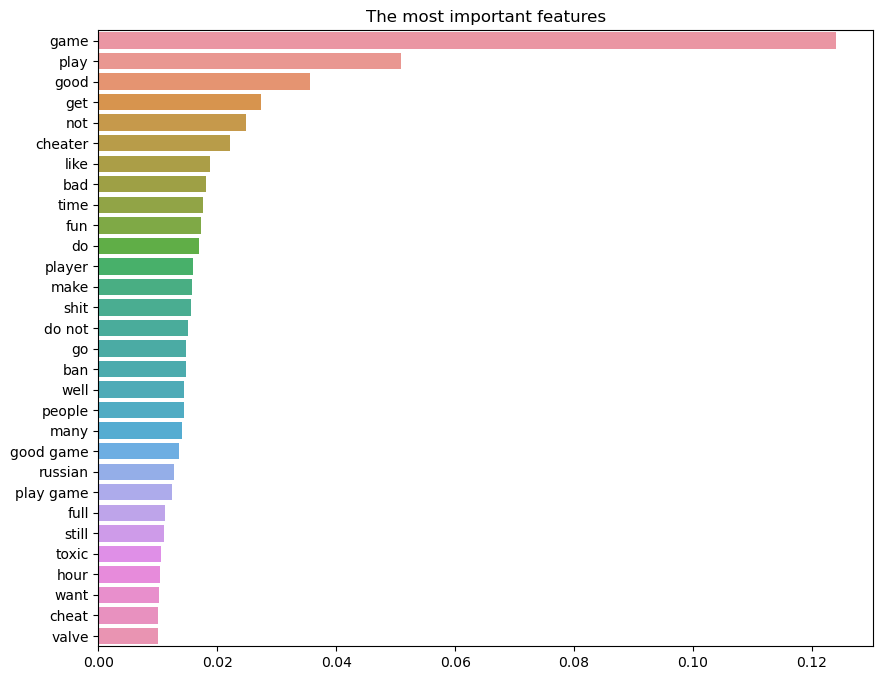

In [43]:
plt.figure(figsize=(10, 8))
mi_imp = [pair[1] for pair in cols_importance[:30]]
cols = [pair[0] for pair in cols_importance[:30]]
sns.barplot(x=mi_imp, y=cols)
plt.title('The most important features')
plt.show()

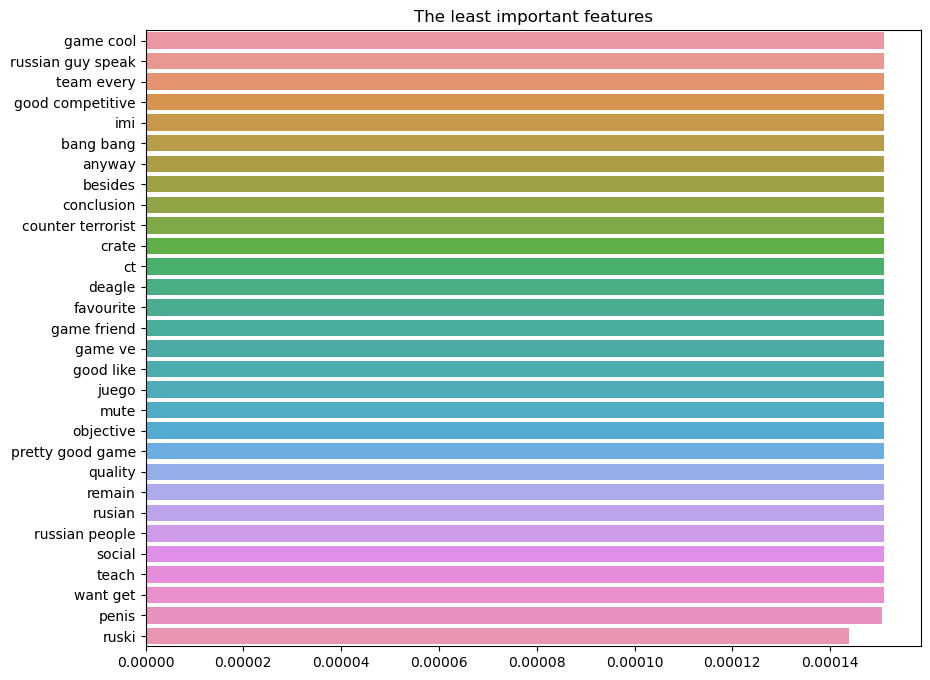

In [44]:
plt.figure(figsize=(10, 8))
mi_imp = [pair[1] for pair in cols_importance[-30:]]
cols = [pair[0] for pair in cols_importance[-30:]]
sns.barplot(x=mi_imp, y=cols)
plt.title('The least important features')
plt.show()

In [45]:
x_train_6k = x_train[[pair[0] for pair in cols_importance[:6000]]]
x_test_6k = x_test[[pair[0] for pair in cols_importance[:6000]]]

In [46]:
# save for the future

# with open('../X_train_6k.pkl', 'wb') as f:
#     pickle.dump(X_train_6k, f)
# with open('../X_test_6k.pkl', 'wb') as f:
#     pickle.dump(X_test_6k, f)
    
# with open('../X_train_6k.pkl', 'rb') as f:
#     X_train_6k = pickle.load(f)
# with open('../X_test_6k.pkl', 'rb') as f:
#     X_test_6k = pickle.load(f)

In [47]:
# leave 6k features
lr = LogisticRegression()
model_cv_lr_6k = train_cv(lr, x_train_6k, y_train, rs_parameters)

bestimator_lr_6k = model_cv_lr_6k.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params {'C': 8.650202519789833, 'l1_ratio': 8.291469073671415, 'penalty': 'l2', 'solver': 'lbfgs'}


In [48]:
print(classification_report(y_test, bestimator_lr_6k.predict(x_test_6k)))

              precision    recall  f1-score   support

    Negative       0.52      0.22      0.31       299
    Positive       0.90      0.97      0.93      2173

    accuracy                           0.88      2472
   macro avg       0.71      0.60      0.62      2472
weighted avg       0.85      0.88      0.86      2472



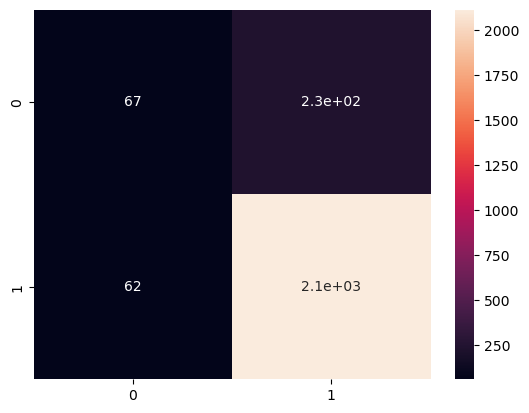

In [49]:
sns.heatmap(confusion_matrix(y_test, bestimator_lr_6k.predict(x_test_6k)), annot=True)
plt.show()

The scores dropped, but not dramatically. The confusion matrix is still diagonal.


## Conclusion
To solve the given task, the raw data was preprocessed the following way:
1. Texts were cleaned from punctuation, urls etc.
2. Texts were lemmatized
3. Texts were vectorized with TF-IDF vectorizer.
4. Categorical features were one-hot-encoded.

Thanks for your attention!
Upvotes and comments are highly appreciated 🙃

Thanks for sparing your time! Do upvote if you liked, This motivates hugely to come up with new explorations and keep exploring new domains.
It would be really nice if you check my other works and if you like my work then don't forget to follow for more interesting notebooks 🤗